In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('train')
test = get_training_data('test')
val = get_training_data('val')

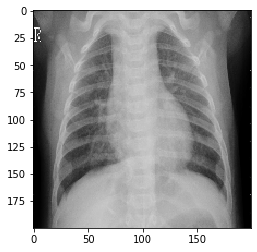

In [4]:
plt.imshow(train[1][0], cmap='gray')

In [5]:
np.random.shuffle(train)
np.random.shuffle(test)
np.random.shuffle(val)

In [6]:
train_X = []
train_y = [] 
test_X = []
test_y = []

for feature, label in train:
    train_X.append(feature)
    train_y.append(label)

for feature, label in test:
    test_X.append(feature)
    test_y.append(label)
    
for feature, label in val:
    train_X.append(feature)
    train_y.append(label)
    
# resize data for deep learning 
train_X = np.array(train_X).reshape(-1, img_size, img_size, 1)
train_y = np.array(train_y)
test_X = np.array(test_X).reshape(-1, img_size, img_size, 1)
test_y = np.array(test_y)

In [7]:
train_X = train_X / 255
test_X = test_X / 255

In [8]:
model = Sequential()

model.add(Conv2D(128, (3, 3), input_shape=train_X.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=1, monitor='val_loss')
adam = Adam(learning_rate=0.01, decay=1.0e-6)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit(train_X, train_y, batch_size=30, epochs=10, validation_split=0.20, callbacks=[early_stop])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4185 samples, validate on 1047 samples
Epoch 1/10
4185/4185 [==============================] - 273s 65ms/sample - loss: 0.3209 - acc: 0.8640 - val_loss: 0.1438 - val_acc: 0.9417
Epoch 2/10
4185/4185 [==============================] - 267s 64ms/sample - loss: 0.1233 - acc: 0.9527 - val_loss: 0.1119 - val_acc: 0.9608
Epoch 3/10
4185/4185 [==============================] - 270s 64ms/sample - loss: 0.0913 - acc: 0.9639 - val_loss: 0.0903 - val_acc: 0.9608
Epoch 4/10
4185/4185 [==============================] - 270s 65ms/sample - loss: 0.0879 - acc: 0.9675 - val_loss: 0.1084 - val_acc: 0.9589


In [9]:
model.evaluate(test_X, test_y)

624/624 [==============================] - 9s 14ms/sample - loss: 1.2865 - acc: 0.7067


[1.2864924027369573, 0.7067308]

In [13]:
pred = model.predict(train_X)
precisions, recalls, thresholds = precision_recall_curve(train_y, pred)
fpr, tpr, thresholds2 = roc_curve(train_y, pred)

In [14]:
predictions = model.predict(test_X)

In [15]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.90)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

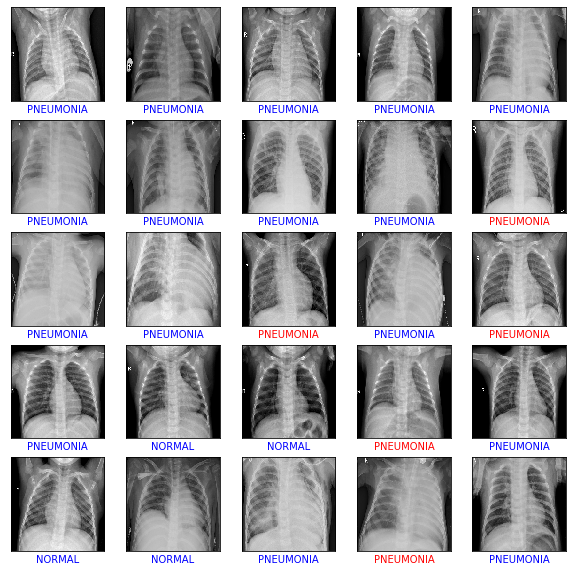

In [16]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_X.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==test_y[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()